## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{DI}{\min{(B_{n}N, B_{lr}O)}} + \frac{DI}{\min{(B_{n}N, B_{lw}O)}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N$ is the number of compute nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


From here, we can expand the model to calculate the performance of Sea. To simplify our understanding of the model, we will break it up into the involved storage components, namely, Lustre, local disk and tmpfs. For simplicity's sake, we will ignore flushing in the model.

The makespan of the Lustre component of Sea can be calculated as follows:

$$M_{sl} = \frac{D}{\min{(B_{n}N, B_{lr}O)}}$$

Where,<br>
$M_{sl}$ is the makespan of the Sea's Lustre component<br>
$D$ is the size of the input dataset<br>
$N$ is the number of compute nodes<br>
$O$ is the number of Lustre OSTs<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>

Unlike the Lustre makespan model, we do not account for Lustre write time here. We choose to make the assumption that all the data can fit on local disks, and the data destined for Lustre will be flushed asynchronously by Sea other than written directly.

The makespan of the tmpfs component of Sea can be described as follows:

$$M_{sm} = \frac{\min(D(I - 1), S - (Ft) * N)}{B_{mr}} + \frac{\min(DI, S - (Ft) * N)}{B_{mw}}$$

Where,<br>
$M_{sm}$ is the makespan of Sea's memory component<br>
$D$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S$ is the amount of available tmpfs storage<br>
$F$ is the size of an individual file<br>
$t$ is the number of threads per node<br>
$N$ is the number of compute nodes<br>
$B_{mr}$ is the read bandwidth of tmpfs<br>
$B_{mw}$ is the write bandwidth of tmpfs<br>

The maximum number of files that can be read from memory is all read data, with the exception of the first read, which can only occur from Lustre. However, depending on the data size, it is very likely that all read data may not be stored in memory, as tmpfs storage is expected to be limited. Sea determines that there is sufficient tmpfs space to execute a write if there is at least enough space for all parallel threads to write a file on tmpfs.

The makespan of disk component of Sea can be described as follows:

$$M_{sd} = \frac{D(I - 1) - \min(D(I - 1), S - (Ft) * N)}{B_{dr}*d*N} + \frac{DI - \min(DI, S - (Ft) * N)}{B_{dw}*d*N}$$

Where,<br>
$M_{sd}$ is the makespan of Sea's disk component<br>
$D$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S$ is the amount of available tmpfs storage<br>
$F$ is the size of an individual file<br>
$t$ is the number of threads per node<br>
$N$ is the number of compute nodes<br>
$d$ is the number of disks per compute node<br>
$B_{dr}$ is the disk read bandwidth<br>
$B_{dw}$ is the disk write bandwidth<br>

Here the number read and written to disk is calculate as the total amount of data to be read and written from local disk minus the amount of read and written data that has been stored in memory. As the parallel bandwidth of disk on a single node may fluctuate with the number of disks uses, the distributed bandwidth of local disk must be multiplied by the number of compute nodes and disks used.

Sea's bandwidth can therefore be calculated as a sum of the individual components. More formally, the makespan of an incrementaion pipeline running alongside Sea can be described as as:

$$M = M_{sl} + M_{sm} + M_{sd}$$

Where,<br>
$M$ is the total makespan<br>
$M_{sl}$ is the makespan of the Lustre component in Sea<br>
$M_{sm}$ is the makespan of the memory component in Sea<br>
$M_{sd}$ is the makespan of the disk component in Sea<br>

In [5]:
import pandas as pd
## bw model

num_files=1000
file_size=617
tmpfs_size=126*1025

# bandwidths
disk_r = 510
disk_w = 426

mem_r = 6760
mem_w = 2560

lustre_r = 200
lustre_w = 191
lustre_disks = 44

network_bw = 4096 #1026
n_nodes = 5

n_threads = 6
n_iterations = 5
n_disks = 6

n_written = num_files * n_iterations # also number of files read from lustre

# we assume that the files prioritized to memory will be read, which is not necessarily true
input_size = num_files * file_size

# local read and writes
local_read = input_size * (n_iterations - 1) # first files read from lustre, last files not read
local_write = input_size * n_iterations

# current setting for writing to tmpfs/disks
avail_tmpfs = tmpfs_size - (file_size * n_threads) * n_nodes
read_mem = min(local_read, avail_tmpfs)
write_mem = min(local_write, avail_tmpfs)

lustre_read = lambda num_read, network_bw, n_nodes : (num_read * file_size) / min (network_bw * n_nodes, lustre_r * lustre_disks)
lustre_write = lambda num_flushed, network_bw, n_nodes : (num_flushed * file_size) / min(network_bw * n_nodes, lustre_w * lustre_disks)

memory_read = lambda n_nodes : read_mem / (mem_r * n_nodes)
memory_write = lambda n_nodes : write_mem / (mem_w * n_nodes)

# assumes the remainder of data fits on disk -- not necessarily true
disk_read = lambda n_nodes,n_disks : (local_read - read_mem) / (disk_r * n_disks * n_nodes)
disk_write = lambda n_nodes,n_disks : (local_write - write_mem) / (disk_w * n_disks * n_nodes)

lustre_mksp = lustre_read(n_written, network_bw, n_nodes) + lustre_write(n_written, network_bw, n_nodes)
sea_last_mksp =  lustre_read(num_files, network_bw, n_nodes) + memory_read(n_nodes) + memory_write(n_nodes) + disk_read(n_nodes, n_disks) + disk_write(n_nodes, n_disks)

print("lustre read:", lustre_read(n_written, network_bw, n_nodes), "lustre write:", lustre_write(n_written, network_bw, n_nodes))
print("disk read:", disk_read(n_nodes, n_disks), "disk write", disk_write(n_nodes, n_disks))
print("memory read:", memory_read(n_nodes), "memory write:", memory_write(n_nodes))


lustre read: 350.5681818181818 lustre write: 367.0871013802951
disk read: 154.07581699346406 disk write 232.73552425665102
memory read: 3.2733727810650888 memory write: 8.64375


In [6]:
df = pd.read_csv("../results/exp_6t_5i_n35.out")
df = df[(df["experiment"].str.contains("5n"))]
df["experiment"] = df["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))


print("Predicted Lustre makespan: ", lustre_mksp, "Actual: ", df[df["experiment"].str.contains("lustre")]["runtime"].mean())
print("Predicted Sea 'last' makespan: ", sea_last_mksp, "Actual: ", df[df["experiment"].str.contains("mem")]["runtime"].mean())


Predicted Lustre makespan:  717.6552831984769 Actual:  788.5855894676
Predicted Sea 'last' makespan:  468.8421003948165 Actual:  542.3694812828


In [7]:
lustre_mksp = lambda network_bw, n_nodes: lustre_read(n_written, network_bw, n_nodes) + lustre_write(n_written, network_bw, n_nodes)
sea_mksp = lambda network_bw, n_nodes, n_disks: lustre_read(num_files, network_bw, n_nodes) + memory_read(n_nodes) + memory_write(n_nodes) + disk_read(n_nodes, n_disks) + disk_write(n_nodes, n_disks)

(0.0, 103.9)

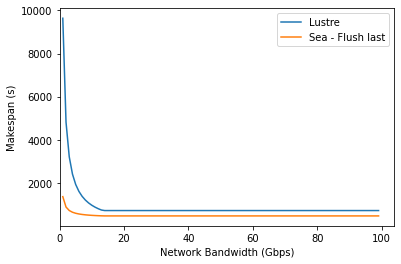

In [8]:
bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

lustre = [lustre_mksp(b, n_nodes) for b in bw]
sea = [sea_mksp(b, n_nodes, n_disks) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre, label="Lustre")
sns.lineplot(x=gbps, y=sea, label="Sea - Flush last")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

Text(0, 0.5, 'Makespan (s)')

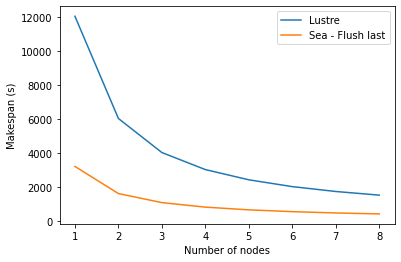

In [9]:
nodes = range(1,9)
b = 4*128
lustre = [lustre_mksp(b, n) for n in nodes]
sea = [sea_mksp(b, n, n_disks) for n in nodes]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=nodes, y=lustre, label="Lustre")
sns.lineplot(x=nodes, y=sea, label="Sea - Flush last")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
#plt.xlim(0,9)

Text(0, 0.5, 'Makespan (s)')

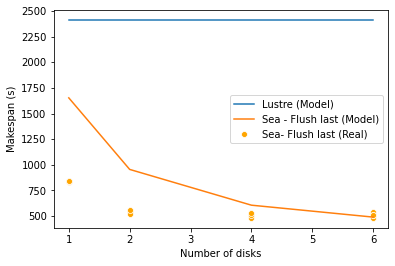

In [10]:
nodes = 5
bw = 4*8
disks = [1, 2, 4, 6] #range(1, 7)

lustre_mksp = lambda network_bw, n_nodes: lustre_read(n_written, network_bw, n_nodes) + lustre_write(n_written, network_bw, n_nodes)
sea_mksp = lambda network_bw, n_nodes, n_disks: lustre_read(num_files, network_bw, n_nodes) + memory_read(n_nodes) *2 + memory_write(n_nodes) + disk_write(n_nodes, n_disks)


lustre = [lustre_mksp(b, nodes) for d in disks]
sea = [sea_mksp(b, nodes, d) for d in disks]


df = pd.read_csv("../results/experiment_disks.out")
df = df[(df["experiment"].str.contains("mem"))]
df["disks"] = df["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df = df.sort_values(by=['disks'])


import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=disks, y=lustre, label="Lustre (Model)")
sns.lineplot(x=disks, y=sea, label="Sea - Flush last (Model)")
sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")
#plt.xlim(0,9)